# Quantitative Measures from ERP signals 

### This tutorial completes our discussion of extracting features from EEG experiments for building relationships with data. 

### We will come back to these EEG measurements when we learn about classifiers.  


## Target Detection Experiment 

### These data were extracted from the ERP CORE (https://osf.io/thsqg/wiki/home/).  

### These are data from the experiment, **Active Visual Oddball P3**

### Some details of the experiment - 
*   The stimulus consists of the letters A, B, C, D, E
*   In any block, one of the 5 letters was designated the "target" with a response with one hand, while the others were designated "standards" with response with the other hand. 
*   The probability of any letter appearing is 0.2.  
*   The probability of a target appearing is 0.2 

#### Load modules that we need 

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from hdf5storage import loadmat, savemat 
from scipy.fftpack import fft
from scipy import signal  #THIS IS NEW!!!

In [2]:
data = loadmat('../Exercises/data/2_P3.mat')

In [3]:
blocktarget = data['blocktarget']
channelnames = data['channelnames']
eeg = data['eeg']
eeg_time = data['eeg_time']
goodtrials = data['goodtrials']
nchannels = data['nchannels']
ntrials = data['ntrials']
response = data['response']
responsetime = data['responsetime']
samplingrate = data['samplingrate']
stimulus = data['stimulus']
target = data['target']

In [4]:
#i like to work in microvolts
eeg = eeg*10**6

## README 

### The information about the datafiles in an experiment is normally placed in a README file. 
### For convenience I am going to place that information here instead.

###  This data was obtained from the archive ERP CORE and reorganized for this class. 
###  Each file contains the data of one participant, indicated in the filename. 
###  The variables contained here are 

*   `ntrials` - number of trials in the experiment 
*   `nchannels` - number of EEG channels 
*   `samplingrate` - number of samples of EEG in per second
*   `eeg` - eegdata of the experiment.  of dimensions, ntrials x nchannels x ntimepoints.  The EEG is provided in units of volts. 
*   `eeg_time` - the time relative to *stimulus onset* in each EEG observation.
*   `channelnames` - the name of the EEG channels indicating where it is located.    
*   `stimulus` - the stimulus presented on each good trial, 1 = A, 2 = B, 3 = C, 4 = D, 5 = E 
*   `target` - the target stimulus on each good trial 1 = A, 2 = B, 3 = C, 4 = D, 5 = E
*   `blocktarget` - indicates which trial had the target on each block, 1 if a target 0 if not a target. 
*   `response` - variable indicating the response accuracy 1 = correct, -1 = incorrect, 0 = no response,
*   `responsetime` - time after stimulus onset when the subject provided a response. 
*   `goodtrials` - vector with value 1 if the trial had a response, 0 if no response or multiple responses.   


#### Plot a single channel (Pz) over Parietal Cortex 

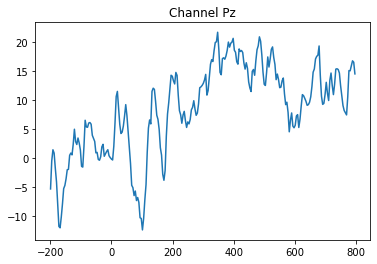

In [5]:
plt.plot(eeg_time,eeg[0,12,:])
plt.title('Channel '+channelnames[12])
plt.show()

#### Plot a few trials of Pz

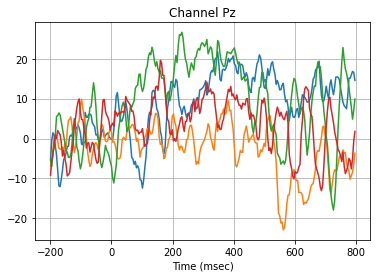

In [6]:
plt.plot(eeg_time,np.transpose(eeg[0:4,12,:]))
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.grid()
plt.show()

#### Compute the Event Related Potential (ERP) by separately averaging the trials for targets and standards 

In [7]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0) # 28 channels and 256 time pointaw becaus eyou avaergae by 40 
erp_standard = np.mean(eeg[(goodtrials == 1)&(blocktarget == 0),:,:],axis =0)

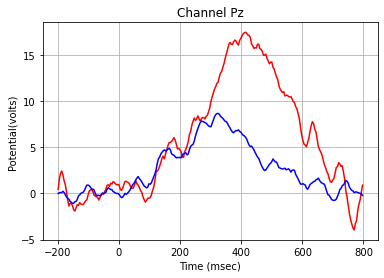

In [8]:
plt.plot(eeg_time,erp_target[12,:],'r')
plt.plot(eeg_time,erp_standard[12,:],'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Potential(volts)')
plt.grid()
plt.show()


#### In this average I take a random set of standards to match the number of targets.  In both cases, I can clearly see a **P300** or **P3** or Central Parietal Positive (**CPP**) potential 

In [9]:
## Lets take care of the random number genearator properly. 
rng = np.random.default_rng(1234)  # The seed can be changed to make a new randomization
###
target_index = np.where(blocktarget > 0)[0]  #notice i had to take the first item from the output to np.where.  This is because where returns it in a list. 
standard_index = np.where(blocktarget == 0)[0] 
rand_standards = rng.permutation(standard_index)
ntargets = len(target_index)
erp_target = np.mean(eeg[target_index,:,:],axis =0)
erp_standard = np.mean(eeg[rand_standards[0:ntargets],:,:],axis =0)


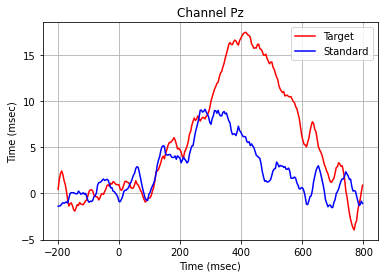

In [10]:
plt.plot(eeg_time,erp_target[12,:],'r') # what channels. is this 
plt.plot(eeg_time,erp_standard[12,:],'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Time (msec)')
plt.grid()
plt.legend(('Target','Standard'))
plt.show()

### Now lets visualize the Event related Potential over the visual areas of the brain

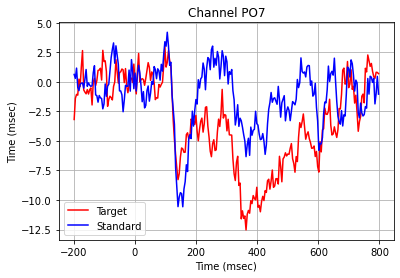

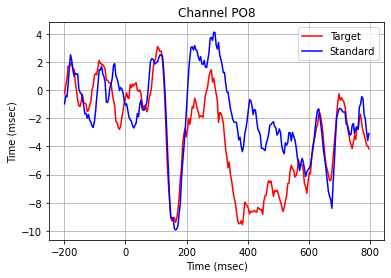

In [11]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erp_target[chans[j],:],'r-')
    plt.plot(eeg_time,erp_standard[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Time (msec)')
    plt.grid()
    plt.legend(('Target','Standard'))

plt.show()

### Frequency Analysis of the Event Related Potential 

#### This is not a standard data analysis method in EEG/MEG/LFP.  This is just an intermediate step I am using for teaching purposes.  

#### I am going to call the fft function here simultaneously for all channels 

In [12]:
T = 1  #duration of the time series 
deltaf = 1/T # frequency resolution 
nsamp = np.shape(erp_standard)[1] #number of samples 
nf = int(nsamp/2) #highest frequency is 1/2 
f = np.arange(0,nf)*deltaf #steps in frequency # ask about thiis  
fft_erp_standard = fft(erp_standard,axis =1) # take the fft, tell it to do it over the time dimension 
amplitude = 2*np.abs(fft_erp_standard)/nsamp/deltaf #compute amplitude in units of microvolts/hz becuase you want to cconver to mucri 

#### Lets plot the same channels as above first for the standards

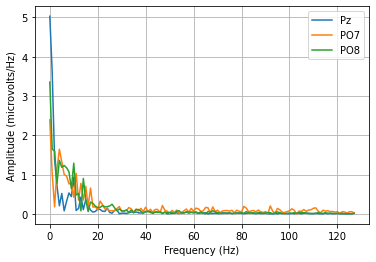

In [35]:
chans = [12,8,25]
for j in range(3):
    plt.plot(f[range(nf)],amplitude[chans[j],range(nf)])
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (microvolts/Hz)')
plt.legend((channelnames[chans[0]],channelnames[chans[1]],channelnames[chans[2]]))

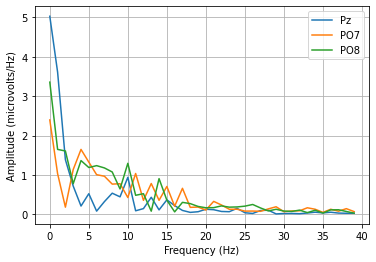

In [14]:
chans = [12,8,25]
maxf = 40 # make highes frequcny 40 # can you explain the frequcciny 
maxbin = int(maxf/deltaf)
for j in range(3):
    plt.plot(f[range(maxbin)],amplitude[chans[j],range(maxbin)])
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (microvolts/Hz)')
plt.legend((channelnames[chans[0]],channelnames[chans[1]],channelnames[chans[2]]))
plt.show()

### Compute the amplitude spectrum of the event related potential for standards and targets. 

In [36]:
T = 1  #duration of the time series 
deltaf = 1/T # frequency resolution 
nsamp = np.shape(erp_standard)[1] #number of samples 
nf = int(nsamp/2) #highest frequency is 1/2 
f = np.arange(0,nf)*deltaf #steps in frequency 
fft_erp_standard = fft(erp_standard,axis =1)
amplitude_standard = 2*np.abs(fft_erp_standard)/nsamp/deltaf
fft_erp_target = fft(erp_target,axis =1)
amplitude_target = 2*np.abs(fft_erp_target)/nsamp/deltaf

### Plot each channel

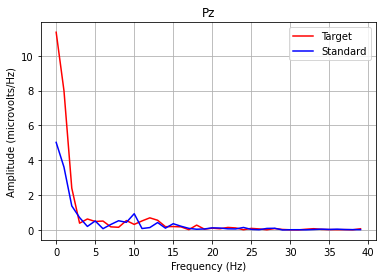

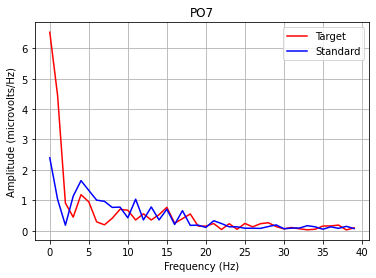

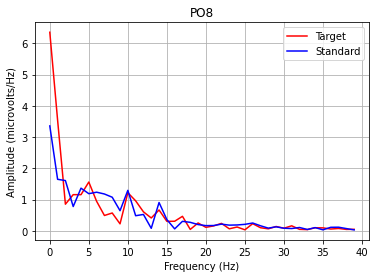

In [37]:
chans = [12,8,25]
maxf = 40
maxbin = int(maxf/deltaf)
for j in range(3):
    plt.figure()
    plt.plot(f[range(maxbin)],amplitude_target[chans[j],range(maxbin)],'r-')
    plt.plot(f[range(maxbin)],amplitude_standard[chans[j],range(maxbin)],'b-')
    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (microvolts/Hz)')
    plt.title(channelnames[chans[j]])
    plt.legend(('Target','Standard'))
    plt.show()


## Digital Filters 

###  A digital filter is a method to control the frequency content of a time-domain signal.  

###  The idea is that we want to keep only certain frequencies in the original signal, while removing other frequencies. 


### Designing a filter can be challenging, but there are really nice tools available.  

### I have created a **module** called `eeg` where I will keep useful functions that I wrote to manipulate eeg data.  

### A module is just a file that contains functions.  (`numpy`, `scipy`, `matplotlib` are all modules)

### for this exercise, we need to import two functions, `makefilter` and `bodeplot` 

In [38]:
from eeg import makefilter,bodeplot
help(makefilter)

Help on function makefilter in module eeg:

makefilter(sr, fp, fs, gp=3, gs=20)
    Wrapper function around scipy filter functions.  
    Makes it convenient by providing frequency parameters in terms of 
    frequencies in Hz.   
    INPUT:  sr - sampling rate in Hz. 
            fp - pass frequency in Hz
            fs - stop frequency in Hz
            gp - pass band ripple in dB, default 3 dB
            gs - stop band attenuation in dB, default 20 dB
    OUTPUT: b,a filter coefficients. 
                    w,h for making bodeplot 
    Automatically detects the type of filter.  if fp < fs the filter
    is low pass but if fp > fs the filter is highpass.  
    It is recommended that you DO NOT use this filter, but instead use 
    makefiltersos to improve stability in high filter order scenarios



#### Lets make a filter that has a pass frequency of 4 Hz and a stop frequency of 8 Hz.  
#### This is called a **low-pass filter** because it is filtering out frequencies above 4 Hz. 
#### This means I want to keep everything below 4 Hz, and I want to absolutely stop everything above 8 Hz. 
#### You always have to allow some width to the transition zone between the pass and stop zones.  

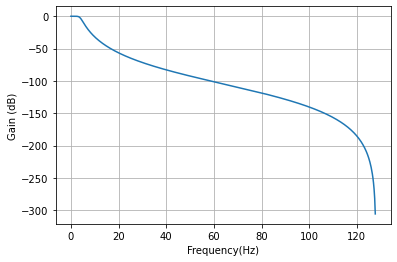

In [39]:
fp = 4 #pass frequency in Hz
fs = 8 #stop frequency in Hz
b,a,w,h = makefilter(samplingrate,fp,fs) # the parameters b and a contain the filter information. 
bodeplot(w,h)# what the fliter is goingto do to signal 
# gain is the log of pin/pout 
#reduct it by a factors of 10 

#### To filter the signal, I can pass my data and my filter design (`b`,`a`) into the `scipy` function `filtfilt` 
#### You can pass all the channels and tell it to filter the along the appropriate axis corresponding to time.   

In [40]:
erpfilt_target = signal.filtfilt(b,a,erp_target,axis=1)  #this applies the filter defined by b,a to the erp_target at every channel 
erpfilt_standard = signal.filtfilt(b,a,erp_standard,axis=1) #this applies the filter defined by b,a to the erp_target at every channel 

#### Compare the filtered signal to the original signal

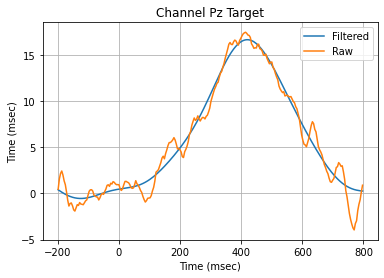

In [41]:
plt.plot(eeg_time,erpfilt_target[12,:])
plt.plot(eeg_time,erp_target[12,:])
plt.title('Channel '+channelnames[12]+ ' Target')
plt.xlabel('Time (msec)')
plt.ylabel('Time (msec)')
plt.grid()
plt.legend(('Filtered','Raw'))
plt.show()
# can you explain the plot was is it dimessiion is time by time 
# does this have the fft and if no why
# why did you not use the fft 


#### Compare the standard and target ERP after filtering

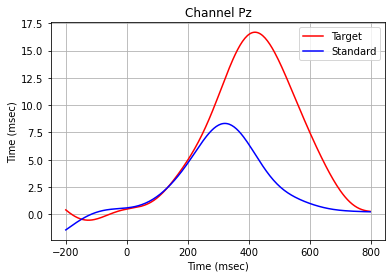

In [21]:
plt.plot(eeg_time,erpfilt_target[12,:],'r')
plt.plot(eeg_time,erpfilt_standard[12,:],'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Time (msec)')
plt.grid()
plt.legend(('Target','Standard'))
plt.show()

## Extract Quantitative measures from the signal  
#### If we want want to do further analysis, we want summary variables that capture quantitatively the brain response.  
#### Such summary variables might be used for a statistical test or for modeling/predicting behavior. 

#### When working with event-related potentials, usually the measures are peak amplitude and peak latency.  

In [42]:
max_standard = np.max(erpfilt_standard[12,:])  #here i find the maximum voltage 
max_index_standard = np.argmax(erpfilt_standard[12,:]) #here I find the latency of the maximum voltage in terms of the index # tell you the inddex and put itin eeg time 
max_time_standard = eeg_time[max_index_standard] #here i convert the index to time after stimulus presentation 
max_target = np.max(erpfilt_target[12,:])
max_index_target = np.argmax(erpfilt_target[12,:])
max_time_target = eeg_time[max_index_target]


## Use of Digital Filters to increase signal to noise ratio 
#### Filters are a method to boost signal and suppress noise.  (Rerun everything with subject 1 and 3 to see what I mean)

#### We can apply the filter to the original EEG data without averaging 


In [23]:
eegfilt = signal.filtfilt(b,a,eeg,axis=2) # The orignal data is trial x chan x time.  hence i filter over axis = 2 # but in thhe whole eeg data 
# A FILTER OVER TIME 

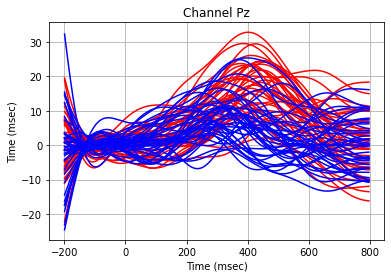

In [24]:
plt.plot(eeg_time,np.transpose(eegfilt[target_index,12,:]),'r')
plt.plot(eeg_time,np.transpose(eegfilt[rand_standards[0:ntargets],12,:]),'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Time (msec)')
plt.grid()
plt.show()
# sorry whaat did you choose in random 
#CAN TELL when a target showed in a indivudal data trial 
# how can you tell that they are looking at a target 

#### Filters have to be carefully designed for isolating specific signals 
#### Here I plot the N170 at channels PO7 and PO8 

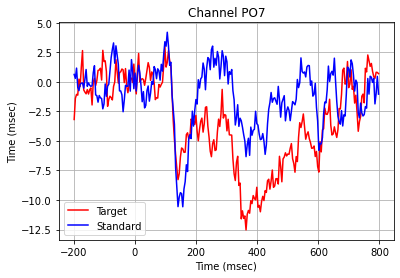

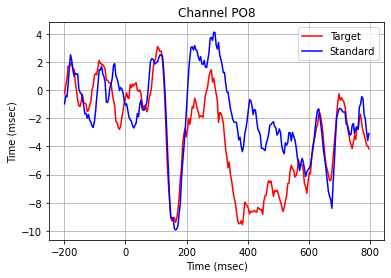

In [25]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erp_target[chans[j],:],'r-')
    plt.plot(eeg_time,erp_standard[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Time (msec)')
    plt.grid()
    plt.legend(('Target','Standard'))

plt.show()

### We had designed and applied a low-pass filter with a cutoff frequency of 4 Hz  

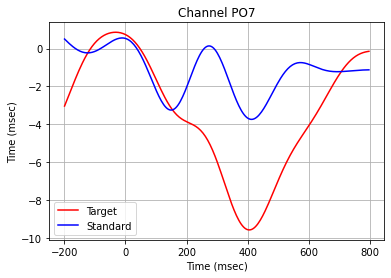

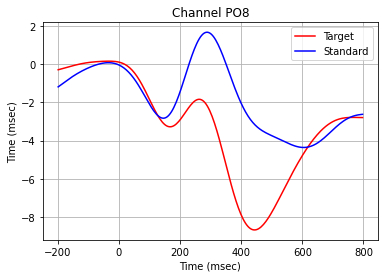

In [26]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erpfilt_target[chans[j],:],'r-')
    plt.plot(eeg_time,erpfilt_standard[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Time (msec)')
    plt.grid()
    plt.legend(('Target','Standard'))

plt.show()

#### I plot again the amplitude spectrum for Pz, PO7, PO8 for the event related potential for standards

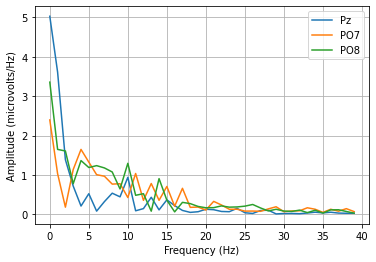

In [27]:
chans = [12,8,25]
maxf = 40
maxbin = int(maxf/deltaf)
for j in range(3):
    plt.plot(f[range(maxbin)],amplitude[chans[j],range(maxbin)])
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (microvolts/Hz)')
plt.legend((channelnames[chans[0]],channelnames[chans[1]],channelnames[chans[2]]))
plt.show()
# does this uust show the enegery in each chaneels 

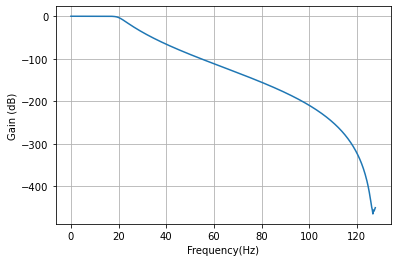

In [28]:
blow,alow,w,h = makefilter(256,20,25) #lowpass filter with the a cutoff of 20 Hz and stop at 25 Hz 
#keeping everything at 20 herts and rolling everytoyt out
bodeplot(w,h)
erpfilt_target = signal.filtfilt(blow,alow,erp_target,axis=1)
erpfilt_standard = signal.filtfilt(blow,alow,erp_standard,axis=1)


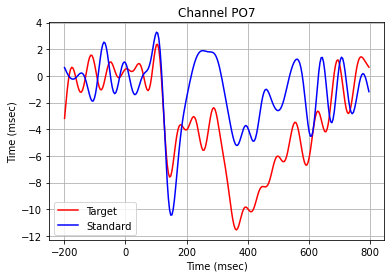

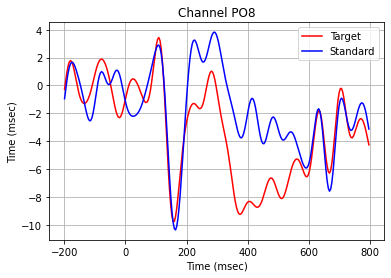

In [29]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erpfilt_target[chans[j],:],'r-')
    plt.plot(eeg_time,erpfilt_standard[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Time (msec)')
    plt.grid()
    plt.legend(('Target','Standard'))

plt.show()

#the problem is the osiliation 

#### I also want to sometimes remove the low frequencies from the data.

#### Lets make a filter that has a pass frequency of 1 Hz and a stop frequency of 0.5 Hz.  
#### This is called a **high-pass filter** because it is filtering out frequencies below 1 Hz. 
#### This means I want to keep everything above 1 Hz, and I want to absolutely stop everything above 0.5 Hz. 
#### You always have to allow some width to the transition zone between the pass and stop zones.   

/Users/lizbethromero/Documents/GitHub/COGS108/108 cog/Lectures/eeg.py:79: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w,20*log10(abs(h)))


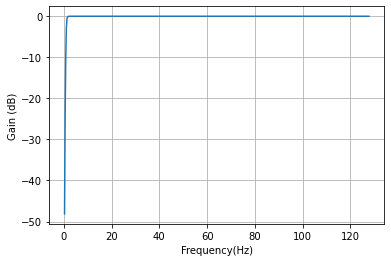

In [49]:
fp = 1
fs = 0.5
bhigh,ahigh,w,h = makefilter(samplingrate,fp,fs)  #Its a high pass filter because fp > fs  
bodeplot(w,h)
# now the fitler as 1 to
# take every one 1 hs and wipes it out 


#### If we apply this to the original data we would highpass filter the data at 1 Hz. 
#### If we apply this to the aleeady lowpass filtered data at 20 Hz, we create a **bandpass** filter, where the data between 1 and 20 Hz has been retained.  

In [50]:
erpfilt_target = signal.filtfilt(bhigh,ahigh,erpfilt_target,axis=1) #notice I apply this to the data already lowpass filtered.  By doing so I've bandpass filtered the data 
erpfilt_standard = signal.filtfilt(bhigh,ahigh,erpfilt_standard,axis=1)

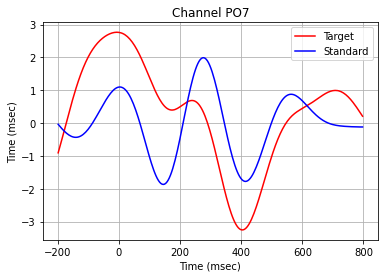

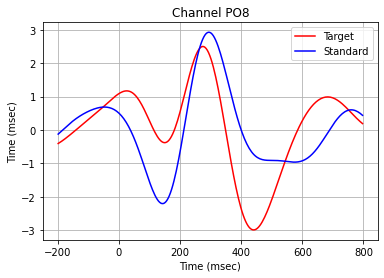

In [46]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erpfilt_target[chans[j],:],'r-')
    plt.plot(eeg_time,erpfilt_standard[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Time (msec)')
    plt.grid()
    plt.legend(('Target','Standard'))

plt.show()

#### Now I can grab quantitative measures 

#### I am going to focus on P08 [25]  

#### We can see a clear negative peak at around 170 ms.  T

#### To measure these, I will compute minimum, but only over a range of samples, 

In [47]:
print(eeg_time[100])

191.40625


In [48]:
maxbin = 100
max_standard = np.min(erpfilt_standard[25,range(maxbin)])  #here i find the minimumvoltage 
max_index_standard = np.argmin(erpfilt_standard[25,range(maxbin)]) #here I find the latency of the maximum voltage in terms of the index 
max_time_standard = eeg_time[max_index_standard] #here i convert the index to time after stimulus presentation 
max_target = np.min(erpfilt_target[25,range(maxbin)])
max_index_target = np.argmin(erpfilt_target[25,range(maxbin)])
max_time_target = eeg_time[max_index_target]